<a href="https://colab.research.google.com/github/ounospanas/AIDL_A_02/blob/main/notebooks_solutions/AIDL_A02_network_optimization_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
#load dataset
import tensorflow as tf
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

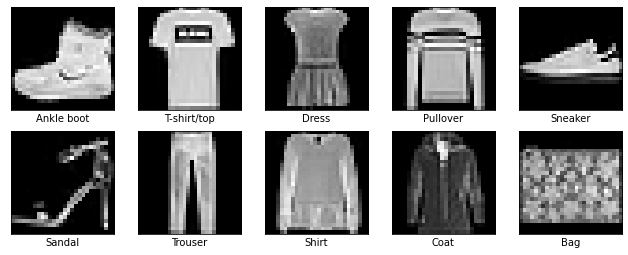

In [5]:
#visualize some data
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
selected = [0,1,3,5,6,8,16,18,19,23]
plt.figure(figsize=(11, 11))
for i, s in enumerate(selected):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    #img = plt.imread(x_train[s])
    plt.imshow(x_train[s], cmap='gray')
    plt.xlabel(classes[y_train[s]],)

In [6]:
# normalize data
x_train = x_train.reshape(x_train.shape[0],-1)/255
x_test = x_test.reshape(x_test.shape[0],-1)/255

# Binary Classification

In [7]:
# select only t-shirts and ankle boots
shirt_train = np.where(y_train==0)
dress_train = np.where(y_train==3)

shirt_test = np.where(y_test==0)
dress_test = np.where(y_test==3)

In [8]:
# concatenate them
x_train_s = x_train[shirt_train]
y_train_s = y_train[shirt_train]

x_test_s = x_test[shirt_test]
y_test_s = y_test[shirt_test]

x_train_d = x_train[dress_train]
y_train_d = y_train[dress_train]

x_test_d = x_test[dress_test]
y_test_d = y_test[dress_test]

x_train_binary = np.concatenate([x_train_s, x_train_d])
x_test_binary = np.concatenate([x_test_s, x_test_d])

y_train_binary = np.concatenate([y_train_s, np.ones_like(y_train_d)])
y_test_binary = np.concatenate([y_test_s, np.ones_like(y_test_d)])

# Neural Network (Custom)

Compute the sigmoid function:
$$sigmoid( w^T x + b) = \frac{1}{1 + e^{-(w^T x + b)}}$$

In [9]:
def sigmoid(z):
    """
    Compute sigmoid function.
    z : the product theta.T * x + b
    Returns
    -------
    g : The sigmoid function.
    """
    a = 1./(1+np.exp(-z))

    return a

$a = ReLU(z) = max(z,0)$

In [10]:
def relu(z):
    """
    Compute relu function.
    z : the product theta.T * x + b
    Returns
    -------
    a : The relu function.
    """
    a = np.maximum(z,0)

    return a

In [11]:
# check relu function
assert relu(-1) == 0
assert relu(2) == 2

# Parameter Initialization

Xavier initialization: $$[-\sqrt{\frac{6}{n_{in}+n_{out}}}, \sqrt{\frac{6}{n_{in}+n_{out}}}]$$

In [12]:
def init_params_xavier(n_in, n_out):
    # TO DO
    # set random seed to 0
    # Hint, check np.random.uniform
    np.random.seed(0)
    # init random params and multiply it with 0.1
    w = np.random.uniform(-np.sqrt(6./(n_in+n_out)), np.sqrt(6./(n_in+n_out)), (n_in, n_out))
    b = np.random.randn(n_out)*0.01
    return w, b

In [13]:
# check init params
w, b  = init_params_xavier(2,3)
print(np.round(w,4) == np.array([[ 0.1069,  0.4715,  0.2251],[ 0.0983, -0.1673,  0.3196]]))
print(np.round(b,4) == np.array([0.0095, -0.0015, -0.001]))

[[ True  True  True]
 [ True  True  True]]
[ True  True  True]


He initialization: $$np.random.randn(n_{in}, n_{out})*\sqrt{\frac{2}{n_{in}}}$$, not multiply using 0.01.

In [14]:
def init_params_he(n_in, n_out):
    # TO DO
    # set random seed to 0
    # Hint, check np.random.uniform
    np.random.seed(0)
    # init random params and multiply it with 0.1
    w = np.random.randn(n_in, n_out)*np.sqrt(2/n_in)
    b = np.random.randn(n_out)*np.sqrt(2/n_in)
    return w, b

In [15]:
# check init params
w, b  = init_params_he(2,3)
print(np.round(w,4) == np.array([[ 1.7641,  0.4002,  0.9787], [ 2.2409,  1.8676, -0.9773]]))
print(np.round(b,4) == np.array([0.9501, -0.1514, -0.1032]))

[[ True  True  True]
 [ True  True  True]]
[ True  True  True]


Calculate the cost function: $J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$

In [16]:
def costFunction(y, m, a):
    """
    Computes cost for linear regression. 
    X : feature vector, shape (m x n+1)
    y : labels (i.e., dog or cat), shape (m, )
    w : parameters for the linear regression, shape (n+1, )
    m: data legth

    returns
    -------
    J : value of cost function.
    """

    J = -1/m * np.sum(y*np.log(a) + (1-y)*np.log(1-a))
    
  
    return J

In [17]:
#forward pass
def forward(X, w, b, activation = 'relu'):
    z = np.dot(X,w) + b
    if activation=='relu':
        a = relu(z)
    else:
        a = sigmoid(z)
    return a

In [18]:
w, b  = init_params_he(2,3)
forward(np.asarray([[1,2],[3,4]]), w, b, 'relu')[0].shape

(3,)

\begin{split}ReLU'(z)= \begin{Bmatrix}1 & z>0 \\ 
0 & z<0 \end{Bmatrix}\end{split}

In [19]:
#relu gradient
def reluBackward(z):
    z[z<=0] = 0
    z[z>0] = 1
    return z

Calculate the derivatives: $$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (A^{(i)}-Y^{(i)})$$

In [20]:
#backpropagation
def backward(a, dz):
    m = len(a)
    dw = np.dot(a.T, dz) / m
    db = np.sum(dz, axis=0, keepdims=True) / m
    
    return dw, db

$$ w_j := w_j - \alpha dw_j $$
$$ b := b - \alpha db $$

In [21]:
# update parameters for optimization
def update(w, b, dw, db, learning_rate=0.01):
    w = w - learning_rate*dw
    b = b - learning_rate*db
    return w, b

In [22]:
#forward pass
def dummy_neural(X, y, n_layer_1, lr = 0.01, epochs = 100):
    parameters = {}
    gradients = {}
    costs = []

    n_in = X.shape[1]
    n_out = 1

    # initialize network with 1 hidden layer (and 1 output of course). 
    # Layer 1 should have 200 neurons
    w1, b1 = init_params_xavier(n_in, n_layer_1)
    w2, b2 = init_params_xavier(n_layer_1, n_out)

    parameters['w1'] = w1
    parameters['b1'] = b1
    parameters['w2'] = w2
    parameters['b2'] = b2

    for i in range(epochs):

        #forward pass
        a1 = forward(X, w1, b1, activation = 'relu')
        a2 = forward(a1, w2, b2, activation = 'sigmoid')
        
        #cost function
        cost = costFunction(y, len(y), a2)
        costs.append(cost)

        #backward pass
        dz2 = a2-y
        dw2, db2 = backward(a2, dz2)
        dz1 = np.dot((dz2),w2.T)*reluBackward(np.dot(X,w1) + b1)
        dw1, db1 = backward(X, dz1)

        gradients['dw1'] = dw1
        gradients['db1'] = db1
        gradients['dw2'] = dw2
        gradients['db2'] = db2

        #update weights
        w2, b2 = update(w2, b2, dw2, db2, lr)
        w1, b1 = update(w1, b1, dw1, db1, lr)

        parameters['w1'] = w1
        parameters['b1'] = b1
        parameters['w2'] = w2
        parameters['b2'] = b2
        
        if i%10==0:
            
            a1t = forward(x_test_binary, w1, b1, activation = 'relu')
            a2t = forward(a1t, w2, b2, activation = 'sigmoid')

            print("epoch {} with cost {}".format(i,cost))
            print("train:", np.mean(np.round(a2)==y))
            print("test:", np.mean(np.round(a2t.reshape(-1))==y_test_binary))

    return parameters, a2, costs, gradients

In [21]:
learning_rate = 0.1
a = dummy_neural(x_train_binary, y_train_binary.reshape(-1,1), 200, learning_rate, 1000)

epoch 0 with cost 0.73222077432145
train: 0.5068333333333334
test: 0.5
epoch 10 with cost 0.3449637483262826
train: 0.8908333333333334
test: 0.882
epoch 20 with cost 0.2831690845443682
train: 0.897
test: 0.894
epoch 30 with cost 0.2593395198965416
train: 0.9028333333333334
test: 0.9015
epoch 40 with cost 0.2452727337640431
train: 0.9095833333333333
test: 0.907
epoch 50 with cost 0.23537812157188362
train: 0.9139166666666667
test: 0.913
epoch 60 with cost 0.22785751996816328
train: 0.9176666666666666
test: 0.917
epoch 70 with cost 0.22213162272876213
train: 0.9193333333333333
test: 0.921
epoch 80 with cost 0.2175448627414139
train: 0.9216666666666666
test: 0.9225
epoch 90 with cost 0.2136466884836102
train: 0.9239166666666667
test: 0.9235
epoch 100 with cost 0.21042192808580462
train: 0.9250833333333334
test: 0.924
epoch 110 with cost 0.20771532431056403
train: 0.927
test: 0.9255
epoch 120 with cost 0.20538208768692795
train: 0.928
test: 0.9275
epoch 130 with cost 0.20328904868104014
tr

In [22]:
# check the test accuracy
a1t = forward(x_test_binary, a[0]['w1'], a[0]['b1'], activation = 'relu')
a2t = forward(a1t, a[0]['w2'], a[0]['b2'], activation = 'sigmoid')
# if you used xavier
# assert np.mean(np.round(a2t.reshape(-1))==y_test_binary) == 0.9255
# if you used he
assert np.mean(np.round(a2t.reshape(-1))==y_test_binary) == 0.9405

# Learning rate scheduling

In [20]:
def lr_scheduling(lr, epoch, schedule = 'step_decay'):

  if schedule=='step_decay':
    #TO DO, every 50 epochs divide lr by 2
    if epoch%50==0:
      lr = lr/2
  elif schedule=='exponential_decay':
    #TO DO, multiply rl every epoch by exp(k), where k = 0.01
    k = 0.01
    lr = lr * np.exp(-k)
  else:
    print('No scheduler, please define a correct scheduler!')

  return lr

In [21]:
lr = 0.1
for i in range(200):
  lr = lr_scheduling(lr, i, schedule = 'step_decay')
assert lr==0.00625

lr = 0.1
for i in range(200):
  lr = lr_scheduling(lr, i, schedule = 'exponential_decay')
assert np.round(lr,4)==0.0135

# Dropout

In [23]:
def dropout_forward(a, keep_prob):
    dr = np.random.rand(a.shape[0], a.shape[1])                   # Step 1: initialize matrix D1 = np.random.rand(..., ...)
    dr = (dr < keep_prob)                                         # Step 2: convert entries of D1 to 0 or 1 (using keep_prob as the threshold)
    a = a*dr                                                      # Step 3: shut down some neurons of A1
    a = a/keep_prob     
    return a, dr

In [24]:
def dropout_backward(da, dr, keep_prob):
    da = da*dr              # Step 1: Apply mask D2 to shut down the same neurons as during the forward propagation
    da = da/keep_prob       # Step 2: Scale the value of neurons that haven't been shut down
    return da

In [28]:
#forward pass
def dummy_neural_dr(X, y, n_layer_1, lr = 0.01, epochs = 100, keep_prob=1.0):
    parameters = {}
    gradients = {}
    costs = []

    n_in = X.shape[1]
    n_out = 1

    # initialize network with 1 hidden layer (and 1 output of course). 
    # Layer 1 should have 200 neurons
    w1, b1 = init_params_xavier(n_in, n_layer_1)
    w2, b2 = init_params_xavier(n_layer_1, n_out)

    parameters['w1'] = w1
    parameters['b1'] = b1
    parameters['w2'] = w2
    parameters['b2'] = b2

    for i in range(epochs):

        #forward pass
        a1 = forward(X, w1, b1, activation = 'relu')
        a1, dr = dropout_forward(a1, keep_prob)
        a2 = forward(a1, w2, b2, activation = 'sigmoid')
        
        #cost function
        cost = costFunction(y, len(y), a2)
        costs.append(cost)

        #backward pass
        dz2 = a2-y
        dw2, db2 = backward(a2, dz2)
        da1 = np.dot((dz2),w2.T)
        da1 = dropout_backward(da1,dr,keep_prob)
        dz1 = da1*reluBackward(np.dot(X,w1) + b1)
        dw1, db1 = backward(X, dz1)

        gradients['dw1'] = dw1
        gradients['db1'] = db1
        gradients['dw2'] = dw2
        gradients['db2'] = db2

        #update weights
        w2, b2 = update(w2, b2, dw2, db2, lr)
        w1, b1 = update(w1, b1, dw1, db1, lr)

        parameters['w1'] = w1
        parameters['b1'] = b1
        parameters['w2'] = w2
        parameters['b2'] = b2
        
        if i%10==0:
            
            a1t = forward(x_test_binary, w1, b1, activation = 'relu')
            a2t = forward(a1t, w2, b2, activation = 'sigmoid')

            print("epoch {} with cost {}".format(i,cost))
            print("train:", np.mean(np.round(a2)==y))
            print("test:", np.mean(np.round(a2t.reshape(-1))==y_test_binary))

    return parameters, a2, costs, gradients

In [29]:
learning_rate = 0.1
a = dummy_neural_dr(x_train_binary, y_train_binary.reshape(-1,1), 200, learning_rate, 1000, 0.8)

epoch 0 with cost 0.7400915087985281
train: 0.5015
test: 0.5
epoch 10 with cost 0.3479958667942149
train: 0.88675
test: 0.883
epoch 20 with cost 0.28823039171222914
train: 0.8973333333333333
test: 0.8935
epoch 30 with cost 0.26628643339401936
train: 0.9026666666666666
test: 0.9035
epoch 40 with cost 0.250557733758381
train: 0.9058333333333334
test: 0.9065
epoch 50 with cost 0.24166767823940236
train: 0.9090833333333334
test: 0.913
epoch 60 with cost 0.23348936992067992
train: 0.9135
test: 0.9165
epoch 70 with cost 0.22803327412241614
train: 0.9165
test: 0.92
epoch 80 with cost 0.22259621810282093
train: 0.9174166666666667
test: 0.9225
epoch 90 with cost 0.21845386209811007
train: 0.92
test: 0.923
epoch 100 with cost 0.21576787803067748
train: 0.9215833333333333
test: 0.9245
epoch 110 with cost 0.21476061539802085
train: 0.9211666666666667
test: 0.9255
epoch 120 with cost 0.2098592280641482
train: 0.9239166666666667
test: 0.9265
epoch 130 with cost 0.20793163021058145
train: 0.926916666

In [30]:
# check the test accuracy
a1t = forward(x_test_binary, a[0]['w1'], a[0]['b1'], activation = 'relu')
a2t = forward(a1t, a[0]['w2'], a[0]['b2'], activation = 'sigmoid')
# if you used xavier
np.mean(np.round(a2t.reshape(-1))==y_test_binary)

0.9405

# Neural Network Binary (Keras)

In [30]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
%matplotlib inline

In [31]:
seed = 2
tf.random.set_seed(seed)
np.random.seed(seed)

model = Sequential()
model.add(Dense(200, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

batch_size = 128
epochs = 200


model.compile(loss="binary_crossentropy", optimizer="sgd", metrics=["accuracy"])
history_1 = model.fit(x_train_binary, y_train_binary, batch_size=batch_size, epochs=epochs, 
          validation_data=(x_test_binary, y_test_binary))

Epoch 1/200
94/94 [==============================] - 4s 7ms/step - loss: 0.4139 - accuracy: 0.8523 - val_loss: 0.3127 - val_accuracy: 0.8840
Epoch 2/200
94/94 [==============================] - 0s 5ms/step - loss: 0.2724 - accuracy: 0.8995 - val_loss: 0.2640 - val_accuracy: 0.8945
Epoch 3/200
94/94 [==============================] - 0s 5ms/step - loss: 0.2373 - accuracy: 0.9098 - val_loss: 0.2397 - val_accuracy: 0.9055
Epoch 4/200
94/94 [==============================] - 0s 5ms/step - loss: 0.2187 - accuracy: 0.9158 - val_loss: 0.2258 - val_accuracy: 0.9130
Epoch 5/200
94/94 [==============================] - 0s 5ms/step - loss: 0.2067 - accuracy: 0.9191 - val_loss: 0.2151 - val_accuracy: 0.9200
Epoch 6/200
94/94 [==============================] - 0s 5ms/step - loss: 0.1979 - accuracy: 0.9222 - val_loss: 0.2095 - val_accuracy: 0.9230
Epoch 7/200
94/94 [==============================] - 0s 5ms/step - loss: 0.1918 - accuracy: 0.9241 - val_loss: 0.2024 - val_accuracy: 0.9260
Epoch 8/200
9

In [32]:
from tensorflow.keras.layers import Dense, Dropout
seed = 2
tf.random.set_seed(seed)
np.random.seed(seed)

model = Sequential()
model.add(Dense(200, activation="relu"))
model.add(Dropout(0.25))
model.add(Dense(1, activation="sigmoid"))

batch_size = 128
epochs = 200


model.compile(loss="binary_crossentropy", optimizer="sgd", metrics=["accuracy"])
history_2 = model.fit(x_train_binary, y_train_binary, batch_size=batch_size, epochs=epochs, 
          validation_data=(x_test_binary, y_test_binary))

Epoch 1/200
94/94 [==============================] - 1s 7ms/step - loss: 0.4285 - accuracy: 0.8330 - val_loss: 0.3137 - val_accuracy: 0.8820
Epoch 2/200
94/94 [==============================] - 0s 5ms/step - loss: 0.2834 - accuracy: 0.8942 - val_loss: 0.2659 - val_accuracy: 0.8940
Epoch 3/200
94/94 [==============================] - 0s 5ms/step - loss: 0.2503 - accuracy: 0.9016 - val_loss: 0.2419 - val_accuracy: 0.9035
Epoch 4/200
94/94 [==============================] - 0s 5ms/step - loss: 0.2313 - accuracy: 0.9091 - val_loss: 0.2281 - val_accuracy: 0.9120
Epoch 5/200
94/94 [==============================] - 0s 5ms/step - loss: 0.2173 - accuracy: 0.9143 - val_loss: 0.2175 - val_accuracy: 0.9190
Epoch 6/200
94/94 [==============================] - 0s 5ms/step - loss: 0.2099 - accuracy: 0.9178 - val_loss: 0.2118 - val_accuracy: 0.9215
Epoch 7/200
94/94 [==============================] - 0s 5ms/step - loss: 0.2034 - accuracy: 0.9188 - val_loss: 0.2054 - val_accuracy: 0.9235
Epoch 8/200
9

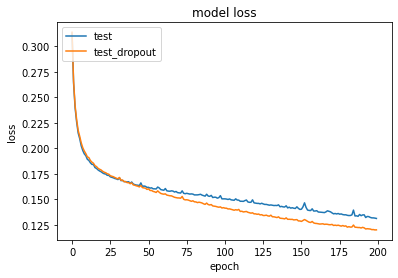

In [33]:
# summarize history for loss
plt.plot(history_1.history['val_loss'])
plt.plot(history_2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['test', 'test_dropout'], loc='upper left')
plt.show()

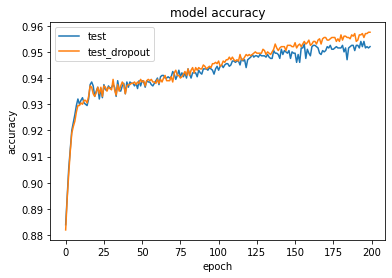

In [34]:
# summarize history for loss
plt.plot(history_1.history['val_accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['test', 'test_dropout'], loc='upper left')
plt.show()

# Validation Set (The CORRECT way of training and evaluation process)

In [37]:
#cross validation example
from sklearn.model_selection import KFold

kfold = KFold(n_splits=5, shuffle=True, random_state=2) # number of folds, shuffle, seed

# enumerate splits
for train, val in kfold.split(x_train_binary):
	print('train: %s, val: %s' % (train, val))

train: [    0     1     3 ... 11997 11998 11999], val: [    2     4    10 ... 11991 11992 11994]
train: [    0     1     2 ... 11997 11998 11999], val: [    3     5     6 ... 11988 11989 11993]
train: [    1     2     3 ... 11994 11995 11996], val: [    0    13    19 ... 11997 11998 11999]
train: [    0     1     2 ... 11997 11998 11999], val: [    7     9    21 ... 11948 11952 11955]
train: [    0     2     3 ... 11997 11998 11999], val: [    1    12    14 ... 11985 11995 11996]


In [38]:
X_train_binary = x_train_binary[train]
Y_train_binary = y_train_binary[train]
X_val_binary = x_train_binary[val]
Y_val_binary = y_train_binary[val]

In [39]:
from tensorflow.keras.callbacks import ModelCheckpoint #save the model version that achieved lower loss!

seed = 2
tf.random.set_seed(seed)
np.random.seed(seed)

model = Sequential()
model.add(Dense(200, activation="relu"))
model.add(Dropout(0.25))
model.add(Dense(1, activation="sigmoid"))

batch_size = 128
epochs = 200

save_model = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=2)

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history_3 = model.fit(X_train_binary, Y_train_binary, batch_size=batch_size, epochs=epochs, callbacks=[save_model],
          validation_data=(X_val_binary, Y_val_binary))

Epoch 1/200
65/75 [=========================>....] - ETA: 0s - loss: 0.2371 - accuracy: 0.9019
Epoch 1: val_loss improved from inf to 0.18887, saving model to best_model.h5
75/75 [==============================] - 1s 7ms/step - loss: 0.2289 - accuracy: 0.9053 - val_loss: 0.1889 - val_accuracy: 0.9250
Epoch 2/200
72/75 [===========================>..] - ETA: 0s - loss: 0.1647 - accuracy: 0.9352
Epoch 2: val_loss improved from 0.18887 to 0.16427, saving model to best_model.h5
75/75 [==============================] - 0s 5ms/step - loss: 0.1640 - accuracy: 0.9357 - val_loss: 0.1643 - val_accuracy: 0.9383
Epoch 3/200
74/75 [============================>.] - ETA: 0s - loss: 0.1445 - accuracy: 0.9459
Epoch 3: val_loss improved from 0.16427 to 0.14632, saving model to best_model.h5
75/75 [==============================] - 0s 5ms/step - loss: 0.1447 - accuracy: 0.9457 - val_loss: 0.1463 - val_accuracy: 0.9425
Epoch 4/200
61/75 [=======================>......] - ETA: 0s - loss: 0.1381 - accuracy

In [40]:
np.mean(np.round(history_3.model.predict(x_test_binary))==y_test_binary.reshape(-1,1))

0.9685

In [41]:
history_3.model.load_weights('best_model.h5')
np.mean(np.round(history_3.model.predict(x_test_binary))==y_test_binary.reshape(-1,1))

0.963

#Automatic hyperparameter search platform -> wandb sweeps

example_1: https://colab.research.google.com/github/wandb/examples/blob/master/colabs/pytorch/Organizing_Hyperparameter_Sweeps_in_PyTorch_with_W%26B.ipynb

example_2: https://colab.research.google.com/drive/181GCGp36_75C2zm7WLxr9U2QjMXXoibt

TO DO:
Using grid search and x[:10000] as val set, so x[10000:] as training execute a dummy hyperparameter on the multiclass classification task (not binary).
Search for 100 epochs:
1. layers: [64, 96, 128]
2. learning rate: [0.001, 0.003, 0.005]
3. dropout: [0.3, 0.4, 0.5]
4. minimize loss

In [42]:
# WandB – Install the W&B library
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.8 MB 5.5 MB/s 
     |████████████████████████████████| 144 kB 45.8 MB/s 
     |████████████████████████████████| 181 kB 46.9 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 


In [43]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
%matplotlib inline

!pip install wandb -qq
import wandb
from wandb.keras import WandbCallback
from tensorflow.keras.callbacks import Callback, ModelCheckpoint,EarlyStopping

!wandb login --relogin
wandb.login() #just click the link and copy paste the pass

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: Currently logged in as: pkasnesis (use `wandb login --relogin` to force relogin)


True

In [44]:
sweep_config = {
    'method': 'grid'
    }

In [45]:
metric = {
    'name': 'loss',
    'goal': 'minimize'   
    }

sweep_config['metric'] = metric

In [46]:
parameters_dict = {
 'learning-rate':{
        'values': [0.001, 0.003, 0.005]
        },
    'fc_layer_size': {
        'values': [128, 256, 512]
        },
    'dropout': {
          'values': [0.3, 0.4, 0.5]
        },
    }

sweep_config['parameters'] = parameters_dict

In [47]:
parameters_dict.update({
    'epochs': {
        'value': 100}
    })

In [48]:
import pprint

pprint.pprint(sweep_config)

{'method': 'grid',
 'metric': {'goal': 'minimize', 'name': 'loss'},
 'parameters': {'dropout': {'values': [0.3, 0.4, 0.5]},
                'epochs': {'value': 100},
                'fc_layer_size': {'values': [128, 256, 512]},
                'learning-rate': {'values': [0.001, 0.003, 0.005]}}}


In [49]:
sweep_id = wandb.sweep(sweep_config, entity="pkasnesis", project="aidl-a02-week5")

Create sweep with ID: nw4riqdk
Sweep URL: https://wandb.ai/pkasnesis/aidl-a02-week5/sweeps/nw4riqdk


In [50]:
X_val = x_train[:10000]
X_train = x_train[10000:]
X_test = x_test

Y_train = tf.keras.utils.to_categorical(y_train[10000:],10)
Y_val = tf.keras.utils.to_categorical(y_train[:10000],10)
Y_test = tf.keras.utils.to_categorical(y_test,10)

In [51]:
# The sweep calls this function with each set of hyperparameters
def train():
    # Default values for hyper-parameters we're going to sweep over
    config_defaults = {
        'learning_rate': 1e-3,
        'dropout': 0.3,
        'fc_layer_size': 128,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config
    
    # Define the model architecture
    model = Sequential()
    model.add(Dense(config.fc_layer_size, activation="relu", input_shape=(x_train.shape[1],)))
    model.add(Dropout(config.dropout))
    model.add(Dense(10, activation="softmax"))

    batch_size = 128

    #save_model = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=2)
    adam = tf.keras.optimizers.Adam(lr=config.learning_rate)

    model.compile(loss="categorical_crossentropy", optimizer=adam, metrics=["accuracy"])
    model.fit(X_train, Y_train, batch_size=batch_size,
              epochs=config.epochs,
              validation_data=(X_val, Y_val),
              callbacks=[WandbCallback(validation_data=(X_val, Y_val), labels=classes),
                          ])#EarlyStopping(patience=10, restore_best_weights=True)


In [53]:
wandb.agent(sweep_id, train)

wandb: Agent Starting Run: wzdqghox with config:
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	fc_layer_size: 256
wandb: 	learning-rate: 0.005
wandb: Ctrl + C detected. Stopping sweep.
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


In [55]:
# restore the model file "model.h5" from a specific run by user "pkasnesis"
# in project "aidl-a02-week5" from run "10pr4joa"
best_model = wandb.restore('model-best.h5', run_path="pkasnesis/aidl-a02-week5/l2ylcagj")

model = Sequential()
model.add(Dense(256, activation="relu", input_shape=(x_train.shape[1],)))
model.add(Dropout(0.1))
model.add(Dense(10, activation="softmax"))

# use the "name" attribute of the returned object if your framework expects a filename, e.g. as in Keras
model.load_weights(best_model.name)

391/391 [==============================] - 2s 5ms/step - loss: 0.2706 - accuracy: 0.9001 - val_loss: 0.2986 - val_accuracy: 0.8913 - _timestamp: 1650283768.0000 - _runtime: 33.0000
Epoch 14/100
 67/391 [====>.........................] - ETA: 2s - loss: 0.2549 - accuracy: 0.9035

In [62]:
print(np.mean(np.argmax(model.predict(X_val),1)==np.argmax(Y_val,1)))

391/391 [==============================] - 4s 9ms/step - loss: 0.1378 - accuracy: 0.9464 - val_loss: 0.3348 - val_accuracy: 0.8990 - _timestamp: 1650283911.0000 - _runtime: 176.0000
Epoch 67/100
168/391 [===========>..................] - ETA: 1s - loss: 0.1371 - accuracy: 0.9464

In [61]:
print(np.mean(np.argmax(model.predict(X_test),1)==np.argmax(Y_test,1)))

391/391 [==============================] - 4s 9ms/step - loss: 0.1549 - accuracy: 0.9412 - val_loss: 0.3138 - val_accuracy: 0.8993 - _timestamp: 1650283874.0000 - _runtime: 139.0000
Epoch 51/100
256/391 [==================>...........] - ETA: 0s - loss: 0.1558 - accuracy: 0.9406